# Simple Flux Calculation
Here I analyse an experiment where I force the latent and sensible heat to only depend on surface temperature.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [347]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'drag_t', 'w_atm', 'q_surf', 'rho', 'ps', 'q_surf', 'ucomp', 'vcomp', 'olr','swdn_toa']  

exp_dir = 'aquaplanet/latent_heat_temp_only/'
# exp_name = 'simple_flux_lhe_calc'
exp_name = 'base'

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = f"k=1"

atm_abs = isca_tools.load_namelist(exp_dir+exp_name)['two_stream_gray_rad_nml']['atm_abs']
albedo = isca_tools.load_namelist(exp_dir+exp_name)['mixed_layer_nml']['albedo_value']
mixed_layer_depth = isca_tools.load_namelist(exp_dir+exp_name)['mixed_layer_nml']['depth']

lat_range = slice(25, 90)               # only consider NH and outside deep tropics
use_time_start = 360*2
ds_use = isca_tools.load_dataset(exp_dir + exp_name)
try:
    ds_use = ds_use[var_keep]
except KeyError:
    remove_keys = []
    for key in var_keep:
        if key not in ds_use:
            print(f'Removing {key} from var_keep')
            remove_keys += [key]
    for key in remove_keys:
        var_keep.remove(key)
    ds_use = ds_use[var_keep]
ds_base = ds_use.isel(pfull=-1)         # only lowest level

In [348]:
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['w_atm_const']
    drag_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['drag_const']
    rh_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['rh_const']
    t_diseqb_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['t_diseqb_const']
    p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['p_surf_const']
    p_atm_approx = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['p_atm_const']
except KeyError:
    w_atm_const = np.nan
    drag_const = np.nan
    rh_const = np.nan
    t_diseqb_const = np.nan
    p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name)['spectral_dynamics_nml']['reference_sea_level_press']
    p_atm_approx = float(ds_base.pfull)*100
if 'no_wishe' in exp_dir:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['w_atm_const']
sigma_near_surf = p_atm_approx / p_surface_approx

if 'do_simple_flux_calc' in isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']:
    do_simple_flux_lhe = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['do_simple_flux_calc']
    do_simple_flux_t = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['do_simple_flux_calc']
elif 'do_simple_flux_lhe_calc' in isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']:
    do_simple_flux_lhe = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['do_simple_flux_lhe_calc']
    do_simple_flux_t = False
else:
    do_simple_flux_lhe = False
    do_simple_flux_t = False

In [349]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

## Check Spin Up
Just sanity check that with simple latent and sensible heat calculations, still converge and $T_s - T_a$ does not go crazy.

In [350]:
show_spin_up = False
if show_spin_up:
    swdn_toa_net = isca_tools.utils.radiation.frierson_net_toa_sw_dwn(ds_base.swdn_toa, ds_base.ps, albedo, atm_abs)
    fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
    isca_tools.plot.spin_up.plot_spin_up(ds_base.olr, swdn_toa_net, ds_base.t_surf, ax=ax);

In [351]:
if show_spin_up:
    fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
    (ds_base.t_surf-ds_base.temp).sel(lat=slice(0, 90)).mean(dim='lon').plot(cbar_kwargs={'label': "$T_s - T_a$"}, ax=ax)
    # plt.ylim(0, 100)

## Check Latent and Sensible Heat Calculations
Below I show that the latent and sensible heat calculations follow that expected from the following equations:

$LH(T_s) \approx L_v \overline{C_q}\rho(T_s - \overline{T_{diseqb}}, \sigma_a \overline{p_s}) \overline{|v|}(q^*(T_s, \overline{p_s}) - \overline{r_a}q^*(T_s - \overline{T_{diseqb}}, \sigma_a \overline{p_s}))$</br>


$SH(T_s) \approx c_p \overline{C_t}\rho(T_s - \overline{T_{diseqb}}, \sigma_a \overline{p_s}) \overline{|v|}\big(T_s(1-\sigma_a^{-\kappa}) + \overline{T_{diseqb}}\sigma_a^{-\kappa}\big)$

The biggest error is in summer at low latitudes, and arises because of a difference in calculation saturation specific humidity.

In [352]:
def get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

def get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False, rh=None):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf*(1-sigma**(-kappa)) + temp_diseqb*sigma**(-kappa))

# Take Annual Zonal Average
def get_annual_zonal_av(var, av_method='mean'):
    if av_method == 'mean':
        var_av = annual_mean(var).mean(dim='lon') 
    elif av_method == 'median':
        var_av = annual_mean(var).median(dim='lon')       # median to remove outlier influence
    return var_av.assign_coords(time=(var_av.time - var_av.time.min()).astype(int))

In [353]:
def get_latent_heat2(temp_surf, temp_a, sphum_a, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

In [354]:
ds = ds_base.sel(lat=lat_range, time=slice(use_time_start, np.inf)).load()
ds['rh'] = ds.sphum / sphum_sat(ds.temp, ds.ps*sigma_near_surf)
ds['temp_diseqb'] = ds.t_surf - ds.temp
if do_simple_flux_lhe:
    ds['flux_lhe_manual'] = get_latent_heat(ds.t_surf, t_diseqb_const, rh_const, p_surface_approx, w_atm_const, drag_const)
else:
    lhe_cont_mean = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), 
                                            ds.rh.mean(dim=['lon', 'time']), p_surface_approx, 
                                            ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                            ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    ds['flux_lhe_manual'] = get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh, ds.ps, ds.w_atm if w_atm_const is np.nan else w_atm_const,
                                            ds.drag_q, virtual=False)
    
    # Do taylor expansion breakdown of contribution to latent heat
    ds['flux_lhe_cont_temp'] = get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh.mean(dim=['lon', 'time']), 
                                               p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    ds['flux_lhe_cont_temp_diseqb'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb, ds.rh.mean(dim=['lon', 'time']), 
                                               p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    ds['flux_lhe_cont_rh'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh, 
                                               p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    ds['flux_lhe_cont_drag'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), 
                                               ds.rh.mean(dim=['lon', 'time']), 
                                               p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q, virtual=False)
    ds['flux_lhe_cont_pressure'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), 
                                               ds.rh.mean(dim=['lon', 'time']), 
                                               ds.ps, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    for key in ds:
        if 'lhe_cont' not in key:
            continue
        ds[key] = ds[key] - lhe_cont_mean
        
    # non-linear terms
    ds['flux_lhe_cont_temp_temp_diseqb_nl'] = \
        get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh.mean(dim=['lon', 'time']), 
                        p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                        ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - \
        ds['flux_lhe_cont_temp'] - ds['flux_lhe_cont_temp_diseqb'] - lhe_cont_mean
    ds['flux_lhe_cont_temp_rh_nl'] = \
        get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh, 
                        p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                        ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - \
        ds['flux_lhe_cont_temp'] - ds['flux_lhe_cont_rh'] - lhe_cont_mean
    ds['flux_lhe_cont_temp_drag_nl'] = \
        get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh.mean(dim=['lon', 'time']), 
                        p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                        ds.drag_q, virtual=False) - \
        ds['flux_lhe_cont_temp'] - ds['flux_lhe_cont_drag'] - lhe_cont_mean
    if w_atm_const is np.nan:
        ds['flux_lhe_cont_wind'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), 
                                                   ds.rh.mean(dim=['lon', 'time']), 
                                                   p_surface_approx, ds.w_atm, 
                                                   ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - lhe_cont_mean
        ds['flux_lhe_cont_temp_wind_nl'] = \
            get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh.mean(dim=['lon', 'time']), 
                            p_surface_approx, ds.w_atm, 
                            ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - \
            ds['flux_lhe_cont_temp'] - ds['flux_lhe_cont_wind'] - lhe_cont_mean
        ds['flux_lhe_cont_temp_temp_diseqb_wind_nl3'] = \
            get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh.mean(dim=['lon', 'time']), 
                            p_surface_approx, ds.w_atm, 
                            ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - \
            ds['flux_lhe_cont_temp'] - ds['flux_lhe_cont_temp_diseqb'] - ds['flux_lhe_cont_temp_temp_diseqb_nl'] - \
            ds['flux_lhe_cont_wind'] - ds['flux_lhe_cont_temp_wind_nl'] - lhe_cont_mean
        ds['flux_lhe_cont_temp_rh_wind_nl3'] = \
            get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh, 
                            p_surface_approx, ds.w_atm, 
                            ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - \
            ds['flux_lhe_cont_temp'] - ds['flux_lhe_cont_rh'] - ds['flux_lhe_cont_temp_rh_nl'] - \
            ds['flux_lhe_cont_wind'] - ds['flux_lhe_cont_temp_wind_nl'] - lhe_cont_mean
        ds['flux_lhe_cont_temp_drag_wind_nl3'] = \
            get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh.mean(dim=['lon', 'time']), 
                            p_surface_approx, ds.w_atm, 
                            ds.drag_q, virtual=False) - \
            ds['flux_lhe_cont_temp'] - ds['flux_lhe_cont_drag'] - ds['flux_lhe_cont_temp_drag_nl'] - \
            ds['flux_lhe_cont_wind'] - ds['flux_lhe_cont_temp_wind_nl'] - lhe_cont_mean
    else:
        for key in ['flux_lhe_cont_wind', 'flux_lhe_cont_temp_wind_nl', 'flux_lhe_cont_temp_temp_diseqb_wind_nl3',
                    'flux_lhe_cont_temp_rh_wind_nl3', 'flux_lhe_cont_temp_drag_wind_nl3']:
            ds[key] = ds['flux_lhe_cont_temp'] * 0
    ds['flux_lhe_cont_temp_pressure_nl'] = \
        get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh.mean(dim=['lon', 'time']), 
                        ds.ps, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                        ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - \
        ds['flux_lhe_cont_temp'] - ds['flux_lhe_cont_pressure'] - lhe_cont_mean
    
    # Sum up all contributions
    ds['flux_lhe_cont_sum'] = ds['flux_lhe_cont_temp'] * 0 + lhe_cont_mean
    for key in ds:
        if ('lhe_cont' not in key) or ('lhe_cont_sum' in key):
            continue
        ds['flux_lhe_cont_sum'] = ds['flux_lhe_cont_sum'] + ds[key]
    # ds['flux_lhe_cont_sum'] = ds['flux_lhe_temp_cont'] + ds['flux_lhe_temp_diseqb_cont'] + ds['flux_lhe_rh_cont'] + \
    #                           ds['flux_lhe_wind_cont'] + ds['flux_lhe_drag_cont'] + ds['flux_lhe_cont_temp_temp_diseqb_nl'] + \
    #                           ds['flux_lhe_cont_temp_rh_nl'] + ds['flux_lhe_cont_temp_drag_nl'] + lhe_cont_mean
if do_simple_flux_t:
    ds['flux_t_manual'] = get_sensible_heat(ds.t_surf, t_diseqb_const, p_surface_approx, w_atm_const, drag_const)
else:
    ds['flux_t_manual'] = get_sensible_heat(ds.t_surf, ds.temp_diseqb, ds.ps, 
                                            ds.w_atm if w_atm_const is np.nan else w_atm_const, ds.drag_t, virtual=False, rh=ds.rh)
ds = get_annual_zonal_av(ds)

In [355]:
plot_smooth = True
smooth_ndays = 20
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays)/smooth_ndays, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

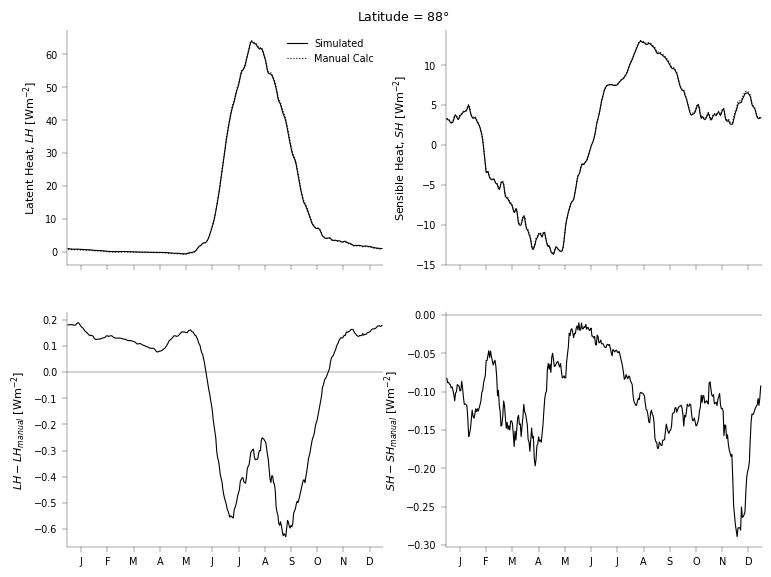

In [356]:
ind_lat_plot = -1

fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
ax[0, 0].plot(ds.time, smooth_func(ds.flux_lhe.isel(lat=ind_lat_plot)), color='k', label='Simulated')
ax[0, 0].plot(ds.time, smooth_func(ds.flux_lhe_manual.isel(lat=ind_lat_plot)), color='k', linestyle=':', label='Manual Calc')
ax[1, 0].plot(ds.time, (smooth_func(ds.flux_lhe.isel(lat=ind_lat_plot))-smooth_func(ds.flux_lhe_manual.isel(lat=ind_lat_plot))), color='k')
ax[1, 0].axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].legend()
ax[0, 0].set_ylabel('Latent Heat, $LH$ [Wm$^{-2}$]')
ax[1, 0].set_ylabel('$LH - LH_{manual}$ [Wm$^{-2}$]')

ax[0, 1].plot(ds.time, smooth_func(ds.flux_t.isel(lat=ind_lat_plot)), color='k')
ax[0, 1].plot(ds.time, smooth_func(ds.flux_t_manual.isel(lat=ind_lat_plot)), color='k', linestyle=':')
ax[1, 1].plot(ds.time, (smooth_func(ds.flux_t.isel(lat=ind_lat_plot))-smooth_func(ds.flux_t_manual.isel(lat=ind_lat_plot))), color='k')
ax[1, 1].axhline(0, color='k', lw=ax_linewidth)
ax[0, 1].set_ylabel('Sensible Heat, $SH$ [Wm$^{-2}$]')
ax[1, 1].set_ylabel('$SH - SH_{manual}$ [Wm$^{-2}$]')

ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(-1, 360)
fig.suptitle(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$', fontsize=9, y=0.91);

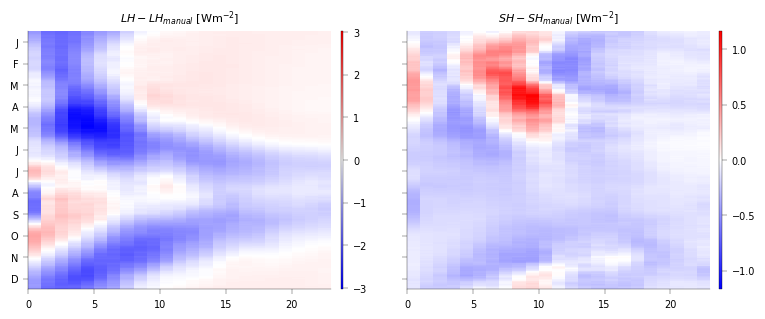

In [357]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
var_plot = smooth_func(ds.flux_lhe, ax=0)-smooth_func(ds.flux_lhe_manual, ax=0)
im = ax[0].pcolormesh(smooth_func(ds.flux_lhe, ax=0)-smooth_func(ds.flux_lhe_manual, ax=0), cmap='bwr', vmin=-np.abs(var_plot).max(), 
                 vmax=np.abs(var_plot).max())
fig.colorbar(im, ax=ax[0], aspect=100, pad=0.03, fraction=0.01)
var_plot = smooth_func(ds.flux_t, ax=0)-smooth_func(ds.flux_t_manual, ax=0)
im = ax[1].pcolormesh(smooth_func(ds.flux_t, ax=0)-smooth_func(ds.flux_t_manual, ax=0), cmap='bwr', 
                      vmin=-np.abs(var_plot).max(), vmax=np.abs(var_plot).max())
fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
ax[0].set_title('$LH - LH_{manual}$ [Wm$^{-2}$]')
ax[1].set_title('$SH - SH_{manual}$ [Wm$^{-2}$]')
ax[0].set_yticks(*month_ticks)
ax[0].set_ylim(-1, 360)
ax[0].invert_yaxis()
ax[0].set_ylabel('')
ax[1].set_ylabel('');

## LH Breakdown
Below I plot how much of the Latent Heat must be explained from the non surface temperature contributions.

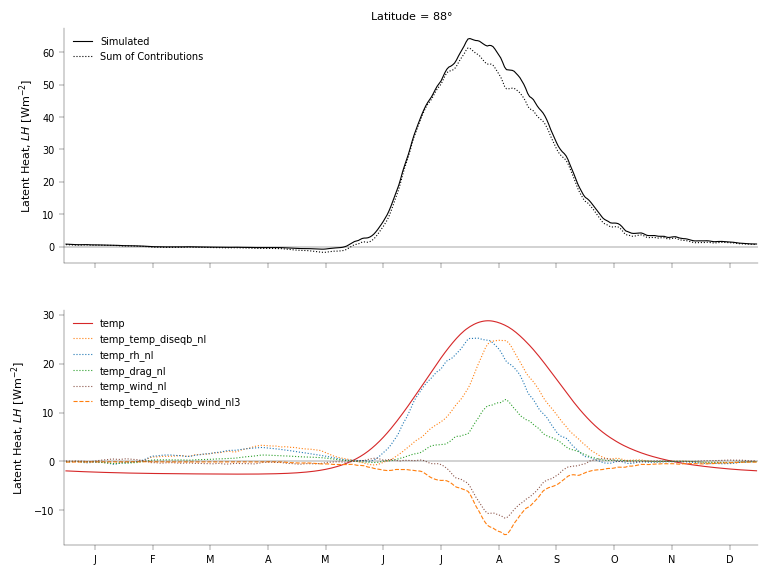

In [358]:
ind_lat_plot=-1
if 'flux_lhe_cont_temp' in ds:
    thresh_flux = 10     # only plot flux contributions with max more than this
    fig, ax = plt.subplots(2, 1, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
    ax[0].plot(ds.time, smooth_func(ds['flux_lhe_manual'].isel(lat=ind_lat_plot)), color='k', label='Simulated')
    ax[0].plot(ds.time, smooth_func(ds['flux_lhe_cont_sum'].isel(lat=ind_lat_plot)), color='k', 
               linestyle=':', label='Sum of Contributions')
    for key in ds:
        if ('lhe_cont' not in key) or ('lhe_cont_sum' in key):
            continue
        if np.abs(smooth_func(ds[key].isel(lat=ind_lat_plot))).max() < thresh_flux:
            continue
        if 'rh' in key:
            color_use = default_colors[0]
        elif 'temp_diseqb' in key:
            color_use = default_colors[1]
        elif 'drag' in key:
            color_use = default_colors[2]
        elif 'pressure' in key:
            color_use = default_colors[4]
        elif 'wind' in key:
            color_use = default_colors[5]
        else:
            color_use = default_colors[3]
        if 'nl3' in key:
            linestyle_use = '--'
        elif 'nl' in key:
            linestyle_use = ':'
        else:
            linestyle_use = '-'
        ax[1].plot(ds.time, smooth_func(ds[key].isel(lat=ind_lat_plot)), color=color_use, 
                   linestyle=linestyle_use, label=key.replace('flux_lhe_cont_', ''))
    ax[0].set_xticks(*month_ticks)
    ax[0].set_xlim(-1, 360)
    ax[0].set_title(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$')
    for i in range(len(ax)):
        ax[i].axhline(0, color='k', lw=ax_linewidth)
        ax[i].legend(loc='upper left', frameon=True, framealpha=1, edgecolor='white')
        ax[i].set_ylabel('Latent Heat, $LH$ [Wm$^{-2}$]')

### Relationship between $T_{diseqb}$, $r_a$ and $T_s$
The above plot shows we cannot neglect seasonal variation in disequilibrium temperature, $T_{diseqb}=T_s-T_a$ and relative humidity, 
$r_a$ when it comes to approximating the latent heat.

So if we want to explain latent heat variation only in terms of $T_s$, we need to find a relationship $T_{diseqb} = f(T_s)$ and $r_{a} = f(T_s)$.

In [359]:
def linear_func(x_var, a, b):
    return a + b*x_var

def linear_func_shift(time, a, b, c, spline):
    x_var_shift = spline(time-c)
    return a + b*x_var_shift

error_func = lambda x, x_approx: np.median(np.abs(x-x_approx))
t_surf_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
                                                       np.append(ds.t_surf.isel(lat=ind_lat_plot), ds.t_surf.isel(lat=ind_lat_plot)[0]), bc_type='periodic')
fit_func_use = lambda x, a, b, c: linear_func_shift(x, a, b, c, spline=t_surf_spline_fit)
rh_params = optimize.curve_fit(fit_func_use, ds.time.to_numpy(), 
                                        ds.rh.isel(lat=ind_lat_plot).to_numpy()*100)[0]
rh_approx = fit_func_use(ds.time, *rh_params)
rh_error = error_func(ds.rh.isel(lat=ind_lat_plot)*100, rh_approx)


temp_diseqb_params = optimize.curve_fit(linear_func, ds.t_surf.isel(lat=ind_lat_plot).to_numpy(), 
                                        ds.temp_diseqb.isel(lat=ind_lat_plot).to_numpy())[0]
temp_diseqb_approx = linear_func(ds.t_surf.isel(lat=ind_lat_plot), *temp_diseqb_params)
temp_diseqb_error = error_func(ds.temp_diseqb.isel(lat=ind_lat_plot), temp_diseqb_approx)

temp_rh_nl = (ds.t_surf.isel(lat=ind_lat_plot)-ds.t_surf.isel(lat=ind_lat_plot).mean())*(
        ds.rh.isel(lat=ind_lat_plot)-ds.rh.isel(lat=ind_lat_plot).mean())
temp_rh_nl_approx = (ds.t_surf.isel(lat=ind_lat_plot)-ds.t_surf.isel(lat=ind_lat_plot).mean())*(
        rh_approx-rh_approx.mean())/100
temp_rh_nl_error = error_func(temp_rh_nl, temp_rh_nl_approx)


temp_temp_diseqb_nl = (ds.t_surf.isel(lat=ind_lat_plot)-ds.t_surf.isel(lat=ind_lat_plot).mean())*(
        ds.temp_diseqb.isel(lat=ind_lat_plot)-ds.temp_diseqb.isel(lat=ind_lat_plot).mean())
temp_temp_diseqb_nl_approx = (ds.t_surf.isel(lat=ind_lat_plot)-ds.t_surf.isel(lat=ind_lat_plot).mean())**2 * temp_diseqb_params[1]
temp_temp_diseqb_nl_error = error_func(temp_temp_diseqb_nl, temp_temp_diseqb_nl_approx)

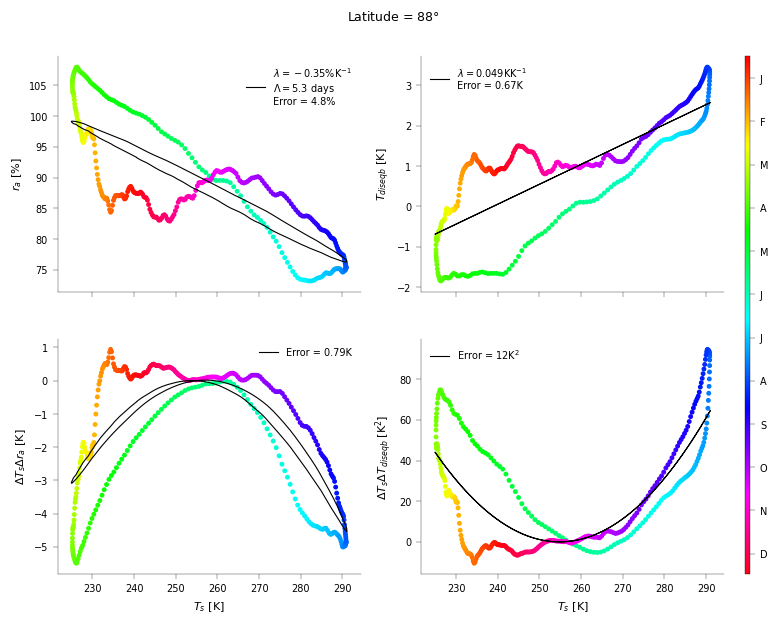

In [360]:
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
ax[0, 0].scatter(smooth_func(ds.t_surf.isel(lat=ind_lat_plot)), smooth_func(ds.rh.isel(lat=ind_lat_plot)*100), c=ds.time, cmap='hsv')
ax[0, 0].plot(ds.t_surf.isel(lat=ind_lat_plot), rh_approx, color='k', label=f'$\lambda={rh_params[-2]:.2g}$%K$^{"{-1}"}$\n'
                                                                         f'$\Lambda={rh_params[-1]:.2g}$ days\n'
                                                                         f'Error = {rh_error:.2g}%')
im = ax[0, 1].scatter(smooth_func(ds.t_surf.isel(lat=ind_lat_plot)), smooth_func(ds.temp_diseqb.isel(lat=ind_lat_plot)), c=ds.time, cmap='hsv')
ax[0, 1].plot(ds.t_surf.isel(lat=ind_lat_plot), temp_diseqb_approx, color='k', label=f'$\lambda={temp_diseqb_params[-1]:.2g}$KK$^{"{-1}"}$\n'
                                                                                  f'Error = {temp_diseqb_error:.2g}K')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)

ax[1, 0].scatter(smooth_func(ds.t_surf.isel(lat=ind_lat_plot)), 
                 smooth_func(temp_rh_nl), c=ds.time, cmap='hsv')
ax[1, 0].plot(ds.t_surf.isel(lat=ind_lat_plot), temp_rh_nl_approx, color='k', 
              label=f'Error = {temp_rh_nl_error:.2g}K')

ax[1, 1].scatter(smooth_func(ds.t_surf.isel(lat=ind_lat_plot)), 
                 smooth_func(temp_temp_diseqb_nl), c=ds.time, cmap='hsv')
ax[1, 1].plot(ds.t_surf.isel(lat=ind_lat_plot), temp_temp_diseqb_nl_approx, color='k', 
              label=f'Error = {temp_temp_diseqb_nl_error:.2g}K$^2$')

for ax_use in ax.flatten():
    ax_use.legend()
ax[0, 0].set_ylabel('$r_a$ [%]')
ax[0, 1].set_ylabel('$T_{diseqb}$ [K]')
ax[1, 0].set_ylabel('$\Delta T_s \Delta r_a$ [K]')
ax[1, 1].set_ylabel('$\Delta T_s \Delta T_{diseqb}$ [K$^2$]')
ax[1, 0].set_xlabel('$T_s$ [K]')
ax[1, 1].set_xlabel('$T_s$ [K]')
fig.suptitle(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$', fontsize=9, y=0.95);

### Relationship between $|v|$, $C_q$ and $T_s$
If the experiments include WISHE, then it is also important to relate the wind speed, $|v|$, and drag coefficient, $|C_q|$ to surface temperature.

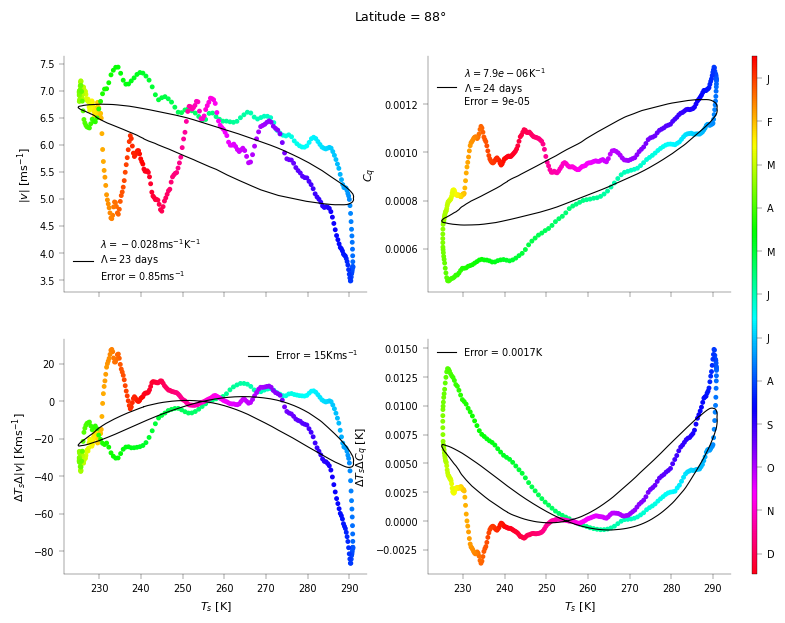

In [361]:
if w_atm_const is np.nan:
    t_surf_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
                                                       np.append(ds.t_surf.isel(lat=ind_lat_plot), ds.t_surf.isel(lat=ind_lat_plot)[0]), bc_type='periodic')
    fit_func_use = lambda x, a, b, c: linear_func_shift(x, a, b, c, spline=t_surf_spline_fit)
    
    # Fit for wind as function of temperature
    wind_params = optimize.curve_fit(fit_func_use, ds.time.to_numpy(), 
                                        ds.w_atm.isel(lat=ind_lat_plot).to_numpy())[0]
    wind_approx = fit_func_use(ds.time, *wind_params)
    wind_error = error_func(ds.w_atm.isel(lat=ind_lat_plot), wind_approx)
    
    temp_wind_nl = (ds.t_surf.isel(lat=ind_lat_plot)-ds.t_surf.isel(lat=ind_lat_plot).mean())*(
        ds.w_atm.isel(lat=ind_lat_plot)-ds.w_atm.isel(lat=ind_lat_plot).mean())
    temp_wind_nl_approx = (ds.t_surf.isel(lat=ind_lat_plot)-ds.t_surf.isel(lat=ind_lat_plot).mean())*(
        wind_approx-wind_approx.mean())
    temp_wind_nl_error = error_func(temp_wind_nl, temp_wind_nl_approx)
    
    # Fit for drag as function of temperature
    drag_params = optimize.curve_fit(fit_func_use, ds.time.to_numpy(), 
                                        ds.drag_q.isel(lat=ind_lat_plot).to_numpy())[0]
    drag_approx = fit_func_use(ds.time, *drag_params)
    drag_error = error_func(ds.drag_q.isel(lat=ind_lat_plot), drag_approx)
    
    temp_drag_nl = (ds.t_surf.isel(lat=ind_lat_plot)-ds.t_surf.isel(lat=ind_lat_plot).mean())*(
        ds.drag_q.isel(lat=ind_lat_plot)-ds.drag_q.isel(lat=ind_lat_plot).mean())
    temp_drag_nl_approx = (ds.t_surf.isel(lat=ind_lat_plot)-ds.t_surf.isel(lat=ind_lat_plot).mean())*(
        drag_approx-drag_approx.mean())
    temp_drag_nl_error = error_func(temp_drag_nl, temp_drag_nl_approx)
    
    
    fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
    im = ax[0, 0].scatter(smooth_func(ds.t_surf.isel(lat=ind_lat_plot)), smooth_func(ds.w_atm.isel(lat=ind_lat_plot)), c=ds.time, cmap='hsv')
    ax[0, 0].plot(ds.t_surf.isel(lat=ind_lat_plot), wind_approx, color='k', label=f'$\lambda={wind_params[-2]:.2g}$ms$^{"{-1}"}$K$^{"{-1}"}$\n'
                                                                         f'$\Lambda={wind_params[-1]:.2g}$ days\n'
                                                                         f'Error = {wind_error:.2g}ms$^{"{-1}"}$')
    ax[0, 1].scatter(smooth_func(ds.t_surf.isel(lat=ind_lat_plot)), smooth_func(ds.drag_q.isel(lat=ind_lat_plot)), c=ds.time, cmap='hsv')
    ax[0, 1].plot(ds.t_surf.isel(lat=ind_lat_plot), drag_approx, color='k', label=f'$\lambda={drag_params[-2]:.2g}$K$^{"{-1}"}$\n'
                                                                         f'$\Lambda={drag_params[-1]:.2g}$ days\n'
                                                                         f'Error = {drag_error:.2g}')
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
    cbar.ax.invert_yaxis()
    cbar.ax.set_yticks(*month_ticks)
    
    ax[1, 0].scatter(smooth_func(ds.t_surf.isel(lat=ind_lat_plot)), 
                 smooth_func(temp_wind_nl), c=ds.time, cmap='hsv')
    ax[1, 0].plot(ds.t_surf.isel(lat=ind_lat_plot), temp_wind_nl_approx, color='k', 
                  label=f'Error = {temp_wind_nl_error:.2g}Kms$^{"{-1}"}$')
    ax[1, 1].scatter(smooth_func(ds.t_surf.isel(lat=ind_lat_plot)), 
                 smooth_func(temp_drag_nl), c=ds.time, cmap='hsv')
    ax[1, 1].plot(ds.t_surf.isel(lat=ind_lat_plot), temp_drag_nl_approx, color='k', 
                  label=f'Error = {temp_drag_nl_error:.2g}K')
    
    for ax_use in ax.flatten():
        ax_use.legend()
    
    ax[0, 0].set_ylabel('$|v|$ [ms$^{-1}$]')
    ax[1, 0].set_ylabel('$\Delta T_s \Delta |v|$ [Kms$^{-1}$]')
    ax[1, 0].set_xlabel('$T_s$ [K]')
    ax[0, 1].set_ylabel('$C_q$')
    ax[1, 1].set_ylabel('$\Delta T_s \Delta C_q$ [K]')
    ax[1, 1].set_xlabel('$T_s$ [K]')
    fig.suptitle(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$', fontsize=9, y=0.95)

In [370]:
def square_func(x_var, a, b, c):
    return a + b*x_var + c*(x_var**2-np.mean(x_var**2))

def square_func2(time, a, b, c, d, d_phase, spline):
    x_var = spline(time)
    x_var_shift_anom = spline(time-d_phase) - np.mean(x_var)
    x_var_anom = x_var - np.mean(x_var)
    return a + b*x_var + c*(x_var_anom**2-np.mean(x_var_anom**2)) + d*(x_var_shift_anom*x_var_anom - np.mean(x_var_shift_anom*x_var_anom))

def quartic_func(x_var, a, b, c, d, e):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_cubed = (x_var-np.mean(x_var))**3
    x_anom_fourth_power = (x_var-np.mean(x_var))**4
    return square_func(x_var, a, b, c) + d*(x_anom_cubed - np.mean(x_anom_cubed)) + \
        e*(x_anom_fourth_power-np.mean(x_anom_fourth_power))

weights_use = np.ones(ds.time.size)*1
weights_use[6*30:9*30-10] = 1
lhe_params2 = optimize.curve_fit(square_func, ds_use.t_surf.to_numpy(), 
                                        ds.flux_lhe.isel(lat=ind_lat_plot).to_numpy(), sigma=weights_use)[0]
lhe_approx2 = square_func(ds_use.t_surf, *lhe_params2)

lhe_params3 = optimize.curve_fit(quartic_func, ds_use.t_surf.to_numpy(), 
                                        ds.flux_lhe.isel(lat=ind_lat_plot).to_numpy(), sigma=weights_use)[0]
lhe_approx3 = quartic_func(ds_use.t_surf, *lhe_params3)

func_use = lambda x,a,b,c,d,d_phase: square_func2(x, a, b, c, d, d_phase, t_surf_spline_fit)
lhe_params4 = optimize.curve_fit(func_use, ds_use.time.to_numpy(), 
                                 ds.flux_lhe.isel(lat=ind_lat_plot).to_numpy(), sigma=weights_use)[0]
lhe_approx4 = func_use(ds_use.time, *lhe_params4)

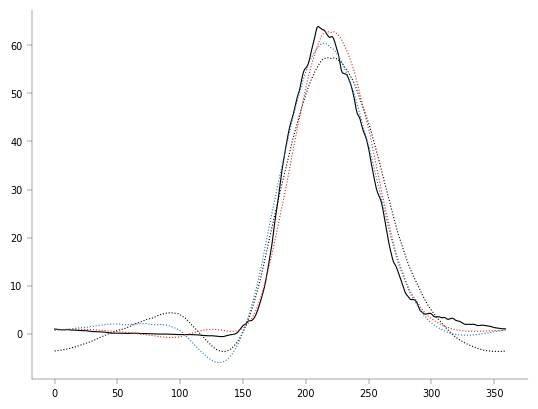

In [371]:
plt.plot(ds.time, smooth_func(ds.flux_lhe.isel(lat=ind_lat_plot)), color='k')
plt.plot(ds.time, lhe_approx2, color='k', linestyle=':')
plt.plot(ds.time, lhe_approx3, color=default_colors[3], linestyle=':')
plt.plot(ds.time, lhe_approx4, color=default_colors[0], linestyle=':')